## 1. Adding imports & installing neccessay packages ##

In [1]:
!pip -q install transformers

     |████████████████████████████████| 4.9 MB 27.1 MB/s 
     |████████████████████████████████| 163 kB 54.5 MB/s 
     |████████████████████████████████| 6.6 MB 48.6 MB/s 


In [2]:
### run this if using google colab to mount google drive as local storage

from google.colab import drive
import os
drive.mount('/content/gdrive')

repo_path = '/content/gdrive/My Drive/colab/NLP-Bootcamp/'

Mounted at /content/gdrive


In [3]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

import tensorflow as tf
import pandas as pd
import numpy as np
import collections
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

## 2. Loading Data ##

In [4]:
### run below 2 lines of code for setting train & test data path on google colab
trainData = os.path.join(repo_path, 'data/sentiment140_160k_tweets_train.csv')
testData = os.path.join(repo_path, 'data/sentiment140_test.csv')

### run below 3 lines of code for setting train & test data path on local machine
'''
DATA = './data/'
trainData = DATA + 'sentiment140_160k_tweets_train.csv'
testData =  DATA + 'sentiment140_test.csv'
'''

train = pd.read_csv(trainData)
test = pd.read_csv(testData)

train.head()

,target,ids,user,text
0,p,1978186076,ceruleanbreeze,"@nocturnalie Anyway, and now Abby and I share ..."
1,p,1994697891,enthusiasticjen,@JoeGigantino Few times I'm trying to leave co...
2,p,2191885992,LifeRemixed,@AngieGriffin Good Morning Angie I'll be in t...
3,p,1753662211,lovemandy,"had a good day driving up mountains, visiting ..."
4,p,2177442789,_LOVELYmanu,downloading some songs i love lady GaGa.


Looking at distribution of *'positives'* & *'negatives'* samples in train dataset 

In [5]:
collections.Counter(train['target'])

Counter({'p': 80000, 'n': 79985})

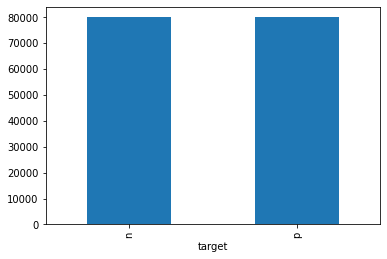

In [6]:
train.groupby('target').size().plot(kind='bar')

We will find that it is a relatively well-balanced dataset

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f80b0d86190>]],
      dtype=object)

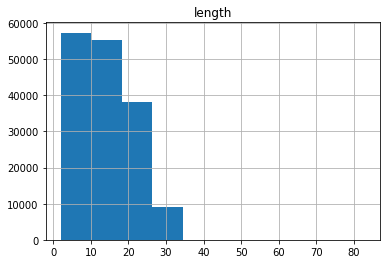

In [7]:
# review text length of training data
# BERT max is 512
train['length'] = train['text'].apply(lambda x: len(x.split(' ')))

train.hist("length", bins=10)

## 3. Data (Text) Preprocessing ##

In [8]:
x_train, x_test, y_train, y_test = train_test_split(train['text'], train['target'], test_size = 0.2, shuffle = True)

In [9]:
# Which model to use?
model_name = 'bert-base-cased' # can handle upper & lower case

# Load a tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load the model
model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels = 2) # num_labels = how many class

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/527M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
train_texts = x_train.tolist()
valid_texts = x_test.tolist()

print(len(train_texts))
train_texts[:5]

127988


["I'm feeling very artistic today  I'm inspired. But i miss my guitar ",
 '@MyGigi71: i feel like total crap. I want him out!!!!!  how was ur dinner.',
 'anyone know how to generate smooth lines with in php with GD? i keep generating jaggy, dud lines ',
 "@FifethAve for my phone i just picked some ppl i wanted their info to get to me, but sometimes i don't get all the messages ",
 'End of lunchbreak. Go back to work ']

## 4. Sentiment Analysis using Deep Learning-based Method: RNN ##

In [11]:
# Pad the tokenizer outputs to the same length for all samples

# tokenize the training data
train_tokens = tokenizer(train_texts,
                         max_length = 64, #max tokenizer
                         truncation = True, #truncate if above 128 tokens
                         padding = 'max_length', #if less than 128 tokens fill to 128
                         add_special_tokens = True,
                         return_token_type_ids = False,
                         return_tensors = 'tf') #pt for pytorch

# tokenize the validation data
valid_tokens = tokenizer(valid_texts,
                         max_length = 64, #max tokenizer
                         truncation = True, #truncate if above 128 tokens
                         padding = 'max_length',
                         add_special_tokens = True,
                         return_token_type_ids = False,
                         return_tensors = 'tf')


In [12]:
train_tokens['input_ids'][0]

<tf.Tensor: shape=(64,), dtype=int32, numpy=
array([ 101,  146,  112,  182, 2296, 1304, 6037, 2052,  146,  112,  182,
       3768,  119, 1252,  178, 5529, 1139, 2092,  102,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)>

In [13]:
# map the labels 
label_map = {'p':1, 'n':0} # for one hot encoding later (start from 0)
label_map

# Map the labels to our dictionary
train_labels = y_train.map(label_map).values
valid_labels = y_test.map(label_map).values

In [14]:
# verifying labels mapping

row = 400

y_train.iloc[row], train_labels[row]

('p', 1)

In [15]:
# optimizer
opt = tf.keras.optimizers.Adam(learning_rate = 5e-5, epsilon = 1e-8) # BERT needs a very low learning rate 
# can use AdamW as well

#loss
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True) # use to do softmax as BERT final model is not softmax

# compile the model
model.compile(optimizer = opt,
              loss = loss,
              metrics = ['accuracy'])
# BLEU score for translation tasks

In [16]:
# lets look at the model
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 108,311,810
Trainable params: 108,311,810
Non-trainable params: 0
_________________________________________________________________


In [17]:
# let's freeze the bert layer & train only the last layer
model.layers[0].trainable = False

model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 108,311,810
Trainable params: 1,538
Non-trainable params: 108,310,272
_________________________________________________________________


In [19]:
# train the model
model.fit(dict(train_tokens), train_labels,
          epochs = 3,
          batch_size = 16, # don't use large batch size for BERT
          validation_data=(dict(valid_tokens), valid_labels),
          verbose = 1)

Epoch 1/3
8000/8000 [==============================] - 1992s 249ms/step - loss: 0.3918 - accuracy: 0.8259 - val_loss: 0.4000 - val_accuracy: 0.8288
Epoch 2/3
8000/8000 [==============================] - 1998s 250ms/step - loss: 0.3223 - accuracy: 0.8632 - val_loss: 0.4001 - val_accuracy: 0.8282
Epoch 3/3
8000/8000 [==============================] - 2002s 250ms/step - loss: 0.2543 - accuracy: 0.8969 - val_loss: 0.4363 - val_accuracy: 0.8191
